In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../app/')
from psa import Strategy, Disease, Psa, Icer
from load_data import data_loader


In [2]:
import os

#file_disease = '../data/Dati Input Disease.xlsx'
#file_strategies = '../data/Dati Input Strategies.xlsx'
#file_costs = '../data/Dati Input Costs.xlsx'
#out_folder = '../output/igenomix_af'

file_disease = '../data/Dati Input Disease_Tier3.xlsx'
file_strategies = '../data/Dati Input Strategies_Tier3.xlsx'
file_costs = '../data/Dati Input Strategy Costs_Tier3.xlsx'
out_folder = '../output/ACMG_Tier3'


os.makedirs('../output_parallel_vs_sequential',exist_ok=True)
os.makedirs(out_folder,exist_ok=True)

# Toy data

In [3]:
# Disease Definitions
d1 = Disease(name='disease1',carrier_rate=0.01,life_expectancy=80,cost=10000)
d2 = Disease(name='disease2',carrier_rate=0.02,life_expectancy=60,cost=20000)
d3 = Disease(name='disease3',carrier_rate=0.005,life_expectancy=40,cost=100000)
disease_dict_fake = {'disease1':d1,'disease2':d2,'disease3':d3}


# Strategies Definition
s0 = Strategy('No testing',disease_list=[],testing_cost=0,disease_dict=disease_dict_fake)
s1 = Strategy('Limited screening',disease_list=['disease2'],testing_cost=1000,disease_dict=disease_dict_fake)
s1_seq = Strategy('Limited screening_seq',testing_mode='sequential',disease_list=['disease2'],testing_cost=1000,disease_dict=disease_dict_fake)
s1_onlyfemale = Strategy('Limited screening_onlyfemale',testing_mode='only_female',disease_list=['disease2'],testing_cost=1000,disease_dict=disease_dict_fake)
s1_seq_conditional = Strategy('Limited screening_seq_cond',testing_mode='sequential_conditional',carrier_rate_th=0.01,disease_list=['disease2'],testing_cost=1000,disease_dict=disease_dict_fake)


s2 = Strategy('Full screening',disease_list=['disease1','disease2','disease3'],testing_cost=1200,disease_dict=disease_dict_fake)

strategy_dict_fake = {'s0':s0,'s1':s1,'s2':s2}




In [4]:
s0.assess_strategy(disease_space=['disease1','disease2','disease3'])

{'p_affected_total': 0.00013125,
 'life_exp': 82.99735624999998,
 'total_cost': 2.875}

In [5]:
s1.assess_strategy(disease_space=['disease1','disease2','disease3'])

{'p_affected_total': 5.729920000000001e-05,
 'life_exp': 82.99905711839999,
 'total_cost': 1002.301504}

In [6]:
s1_seq.assess_strategy(disease_space=['disease1','disease2','disease3'])

{'p_affected_total': 5.729920000000001e-05,
 'life_exp': 82.99905711839999,
 'total_cost': 512.301504}

In [7]:
s1_onlyfemale.assess_strategy(disease_space=['disease1','disease2','disease3'])

{'p_affected_total': 0.00013125,
 'life_exp': 82.99735624999998,
 'total_cost': 502.875}

In [8]:
s1_seq_conditional.assess_strategy(disease_space=['disease1','disease2','disease3'])

{'p_affected_total': 5.729920000000001e-05,
 'life_exp': 82.99905711839999,
 'total_cost': 512.301504}

In [9]:
icer1 = Icer(s2,s1)
icer1.compute_icer()
display(icer1.icer)
display(icer1.delta_years)
display(icer1.delta_costs)

785331.5958672068

0.0002542058750094611

199.6359054999998

In [10]:
icer1 = Icer(s1_seq,s1)
icer1.compute_icer()
display(icer1.icer)
display(icer1.delta_years)
display(icer1.delta_costs)

/home/matteo/Work/Projects/Repos/ECSCostEffectiveness/notebook/../app/psa.py:212: RuntimeWarning: divide by zero encountered in double_scalars
  icer = delta_costs / delta_years


-inf

0.0

-490.0

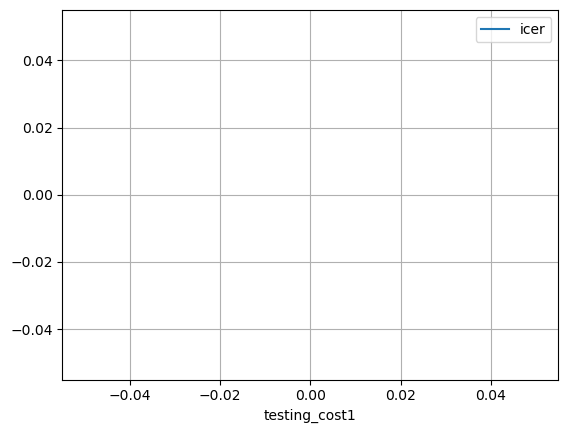

In [11]:
icer1.univariate_sensitivity('testing_cost1',0,12000,50)
icer1.plot_sensitivity()

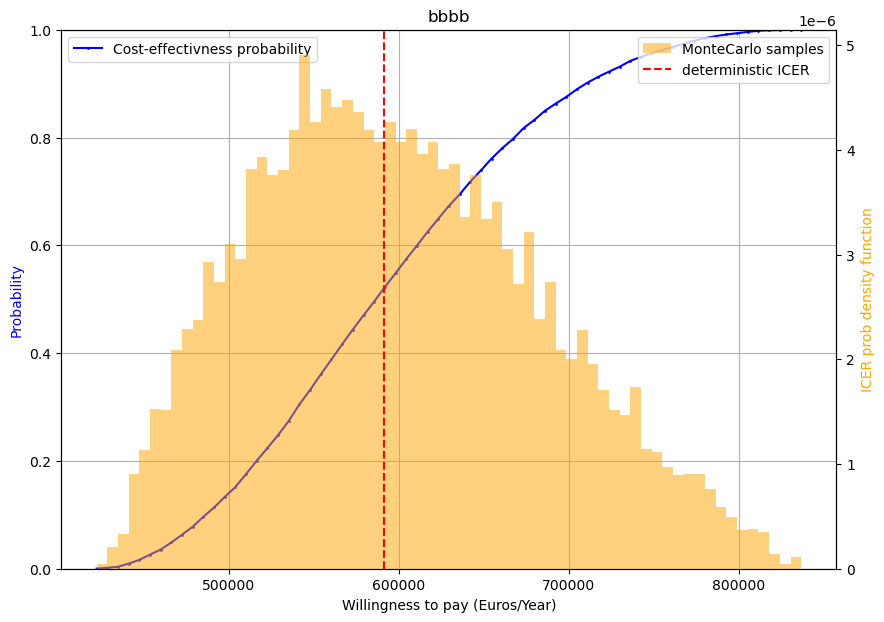

In [12]:
psa = Psa(s2,s0)
psa.run_mc(disease_space=['disease1','disease2','disease3'],
    intervention_cost_lb=2000, intervention_cost_ub=3000,
       testing_cost1_lb=1000, testing_cost1_ub=1300,
        testing_cost2_lb=0, testing_cost2_ub=0,
        eps_cs_lb=0,eps_cs_ub=0.02,
        eps_pgt_lb=0,eps_pgt_ub=0.02,
        rho_notint_lb=0.1,rho_notint_ub=0.4,nsim=10000)

psa.plot_ceac_hist(title='bbbb')

# Load real data

In [13]:


dl = data_loader(file_disease,file_strategies,file_costs=file_costs)



In [14]:
dl.disease_dict['Alpha-thalassemia (HBA1 and HBA2)'].__str__()

'Alpha-thalassemia (HBA1 and HBA2)'

In [15]:
set([dl.disease_dict[x].inheritance for x in dl.disease_dict])

{'X-linked recessive', 'recessive'}

In [16]:
dl.disease_dict['Alpha-thalassemia (HBA1 and HBA2)']

Disease: Alpha-thalassemia (HBA1 and HBA2)

In [17]:
for strategy in dl.strategy_dict.keys():

    display(strategy,
            dl.strategy_dict[strategy].assess_strategy(intervention_cost=19714,eps_cs=0,eps_pgt=0))

'Strategy B - Focused Screening'

{'p_affected_total': 0.0006255558380109074,
 'life_exp': 82.9926096556123,
 'total_cost': 1360.3176881379397}

'Strategy A - ACMG tier 1'

{'p_affected_total': 0.00022796556110962207,
 'life_exp': 82.99088727518385,
 'total_cost': 450.9942794053267}

'Strategy C  - ACMG tier 3'

{'p_affected_total': 0.0011447036677932798,
 'life_exp': 82.98278506221948,
 'total_cost': 1668.6452643950397}

'No testing'

{'p_affected_total': 0, 'life_exp': 83, 'total_cost': 0}

# cost effectivness plane

In [18]:
dl.strategy_dict.keys()

dict_keys(['Strategy B - Focused Screening', 'Strategy A - ACMG tier 1', 'Strategy C  - ACMG tier 3', 'No testing'])

In [19]:
import pandas as pd
df_icer = pd.DataFrame()

for comparison in [
                  #('Strategy A1 (MS)','No testing'),
    ('Strategy A - ACMG tier 1','No testing'),
    ('Strategy B - Focused Screening','No testing'),
                  ('Strategy C  - ACMG tier 3','No testing'),
                  #('Strategy A1 (MS)','Strategy C (ACOG)'),
                  #('Strategy A1 (MS)','Strategy D (ACMG)'),
                  #('Strategy A (FS)','Strategy C (ACOG)'),
                  #('Strategy A (FS)','Strategy D (ACMG)'),
                  #('Strategy A (FS)','Strategy A1 (MS)'),
                   ('Strategy C  - ACMG tier 3','Strategy A - ACMG tier 1'),
                    ('Strategy C  - ACMG tier 3','Strategy B - Focused Screening'),
                       ('Strategy B - Focused Screening','Strategy A - ACMG tier 1'),

                  ]:
    strategy1 = comparison[0]
    strategy2 = comparison[1]

    icer1 = Icer(dl.strategy_dict[strategy1],dl.strategy_dict[strategy2],
                 eps_cs=0,eps_pgt=0,intervention_cost=19714)
    icer1.compute_icer()
    #display(icer1.disease_space)
    df_icer = df_icer.append(
        {'strategy1':strategy1,'strategy2':strategy2,
           'icer':icer1.icer,
           'total cost1':icer1.total_cost1,
           'total cost2':icer1.total_cost2,
           'life exp1':icer1.life_exp1,
           'life exp2':icer1.life_exp2,
          'benefit difference (years)':icer1.life_exp1-icer1.life_exp2,
        'cost difference (Euros)':icer1.total_cost1-icer1.total_cost2},ignore_index=True)

df_icer['cfr'] = df_icer['strategy1'].str.split('-').apply(lambda x: x[-1])+' vs '+df_icer['strategy2'].str.split('-').apply(lambda x: x[-1])

/tmp/ipykernel_38867/269318280.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer = df_icer.append(
/tmp/ipykernel_38867/269318280.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer = df_icer.append(
/tmp/ipykernel_38867/269318280.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer = df_icer.append(
/tmp/ipykernel_38867/269318280.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer = df_icer.append(
/tmp/ipykernel_38867/269318280.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer = df_icer.append(
/tmp/

In [20]:
df_icer.columns

Index(['strategy1', 'strategy2', 'icer', 'total cost1', 'total cost2',
       'life exp1', 'life exp2', 'benefit difference (years)',
       'cost difference (Euros)', 'cfr'],
      dtype='object')

In [21]:


df_icer

,strategy1,strategy2,icer,total cost1,total cost2,life exp1,life exp2,benefit difference (years),cost difference (Euros),cfr
0,Strategy A - ACMG tier 1,No testing,-15261.028972,450.994279,916.574972,82.990887,82.960379,0.030508,-465.580692,ACMG tier 1 vs No testing
1,Strategy B - Focused Screening,No testing,-107599.201987,1360.317688,4022.492784,82.992610,82.967868,0.024742,-2662.175096,Focused Screening vs No testing
2,Strategy C - ACMG tier 3,No testing,-47728.064971,1668.645264,4419.338591,82.982785,82.925152,0.057633,-2750.693326,ACMG tier 3 vs No testing
3,Strategy C - ACMG tier 3,Strategy A - ACMG tier 1,-84244.405131,1668.645264,3953.757898,82.982785,82.955660,0.027125,-2285.112634,ACMG tier 3 vs ACMG tier 1
4,Strategy C - ACMG tier 3,Strategy B - Focused Screening,-2691.257468,1668.645264,1757.163495,82.982785,82.949894,0.032891,-88.518230,ACMG tier 3 vs Focused Screening
5,Strategy B - Focused Screening,Strategy A - ACMG tier 1,380941.161572,1432.892479,3629.486883,82.980353,82.986119,-0.005766,-2196.594404,Focused Screening vs ACMG tier 1


In [22]:
df_icer[['strategy1','strategy2','icer','benefit difference (years)', 'cost difference (Euros)','life exp1', 'life exp2','total cost1',
       'total cost2']].to_excel(os.path.join(out_folder,'icer.xlsx'))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


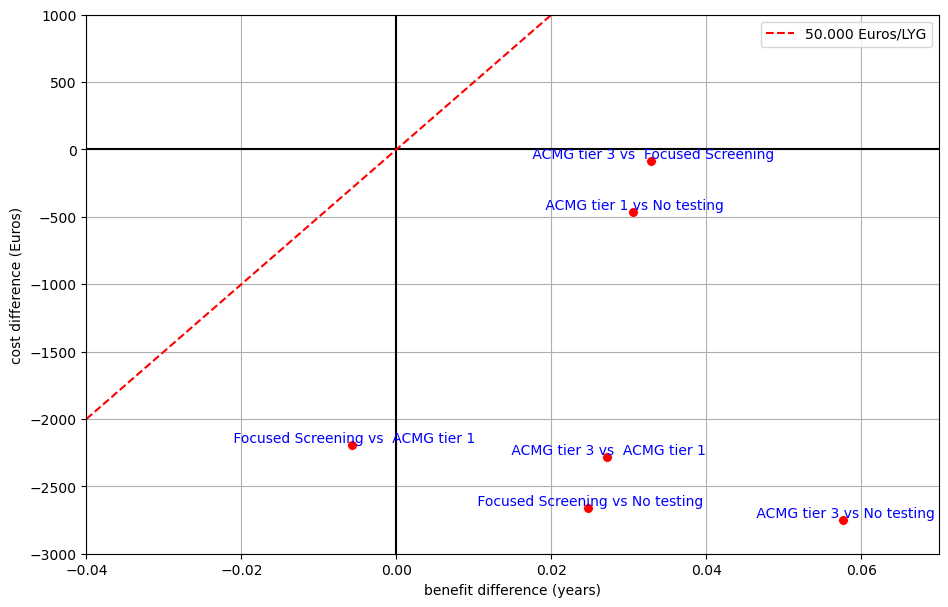

In [23]:
import seaborn as sns
from matplotlib import pyplot as plt

fig,ax = plt.subplots(figsize=(11,7))

sns.scatterplot(ax=ax,data = df_icer,x='benefit difference (years)',y='cost difference (Euros)',color='r',s=50)

plt.axhline(0,c='k')
plt.axvline(0,c='k')
plt.xlim([-0.04,0.07])
plt.ylim([-3000,1000])

icer_th = 50000
x1 = -0.04
x2 = 0.07
plt.plot([x1,x2],[x1*icer_th,x2*icer_th],ls='--',c='r',label='50.000 Euros/LYG')

for line in range(0,df_icer.shape[0]):
     plt.text(df_icer['benefit difference (years)'][line],
              df_icer['cost difference (Euros)'][line], 
              df_icer['cfr'][line], horizontalalignment='center', verticalalignment='bottom', size='medium', color='blue')#, weight='semibold')
plt.legend()
plt.grid()
plt.savefig(os.path.join(out_folder,'cost_effectivness_plane.jpeg'))
plt.savefig(os.path.join(out_folder,'cost_effectivness_plane.eps'))

# Parallelel vs Sequential testing

In [24]:
import copy

strategy_sequential = copy.deepcopy(dl.strategy_dict['Strategy C  - ACMG tier 3'])
strategy_sequential.testing_mode = 'sequential'
strategy_sequential.update_cost()
print(strategy_sequential.testing_mode)

strategy_parallel = copy.deepcopy(dl.strategy_dict['Strategy C  - ACMG tier 3'])
strategy_parallel.testing_mode = 'parallel'
strategy_parallel.update_cost()
print(strategy_parallel.testing_mode)

strategy_female = copy.deepcopy(dl.strategy_dict['Strategy C  - ACMG tier 3'])
strategy_female.testing_mode = 'only_female'
strategy_female.update_cost()
print(strategy_female.testing_mode)

strategy_seq_cond = copy.deepcopy(dl.strategy_dict['Strategy C  - ACMG tier 3'])
strategy_seq_cond.testing_mode = 'sequential_conditional'
strategy_seq_cond.carrier_rate_th = 0.01
strategy_seq_cond.update_cost()
print(strategy_seq_cond.testing_mode)




sequential
parallel
only_female
sequential_conditional


In [25]:
print(strategy_sequential.testing_cost_couple)
print(strategy_sequential.testing_cost)
print(strategy_sequential.pmale_testing)

350
242.20463637591516
0.3840264935766581


In [26]:
print(strategy_seq_cond.testing_cost_couple)
print(strategy_seq_cond.testing_cost)
print(strategy_seq_cond.pmale_testing)

350
212.76828508431964
0.2158187719103979


In [27]:
df_icer_seq = pd.DataFrame()

strategy_parallel = copy.deepcopy(dl.strategy_dict['Strategy C  - ACMG tier 3'])
strategy_parallel.testing_mode = 'parallel'
strategy_parallel.update_cost()
print(strategy_parallel.testing_mode)

for carrier_rate_th in [0,0.00001,0.0001,0.0005,0.001,0.003,0.005,0.01,0.02,0.03,0.04,0.05,0.08,1]: 
    
    strategy_seq_cond = copy.deepcopy(dl.strategy_dict['Strategy C  - ACMG tier 3'])
    strategy_seq_cond.testing_mode = 'sequential_conditional'
    strategy_seq_cond.carrier_rate_th = carrier_rate_th
    strategy_seq_cond.update_cost()

                 

    icer1 = Icer(strategy_parallel,strategy_seq_cond,
                 eps_cs=0,eps_pgt=0,intervention_cost=19714)
    icer1.compute_icer()
    #display(icer1.disease_space)
    df_icer_seq = df_icer_seq.append(
        {'threshold':carrier_rate_th,
           'icer':icer1.icer,
           'total cost1':icer1.total_cost1,
           'total cost2':icer1.total_cost2,
           'life exp1':icer1.life_exp1,
           'life exp2':icer1.life_exp2,
          'benefit difference (years)':icer1.life_exp1-icer1.life_exp2,
        'cost difference (Euros)':icer1.total_cost1-icer1.total_cost2,
        'pmale_parallel':strategy_parallel.pmale_testing,
        'testing_cost_parallel':strategy_parallel.testing_cost,
        'pmale_sequential':strategy_seq_cond.pmale_testing,
        'testing_cost_sequential':strategy_seq_cond.testing_cost},ignore_index=True)



parallel


/home/matteo/Work/Projects/Repos/ECSCostEffectiveness/notebook/../app/psa.py:212: RuntimeWarning: divide by zero encountered in double_scalars
  icer = delta_costs / delta_years
/tmp/ipykernel_38867/757737678.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_seq = df_icer_seq.append(
/home/matteo/Work/Projects/Repos/ECSCostEffectiveness/notebook/../app/psa.py:212: RuntimeWarning: divide by zero encountered in double_scalars
  icer = delta_costs / delta_years
/tmp/ipykernel_38867/757737678.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_seq = df_icer_seq.append(
/tmp/ipykernel_38867/757737678.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_seq = df_icer_seq.append(
/tmp/ipykernel_38867/75

In [28]:
df_icer_seq.to_excel('Parallel_vs_Sequential.xlsx',index=False)
df_icer_seq

,threshold,icer,total cost1,total cost2,life exp1,life exp2,benefit difference (years),cost difference (Euros),pmale_parallel,testing_cost_parallel,pmale_sequential,testing_cost_sequential
0,0.00000,inf,1668.645264,1560.849901,82.982785,82.982785,0.000000e+00,107.795364,1.0,350.0,0.384026,242.204636
1,0.00001,inf,1668.645264,1560.849901,82.982785,82.982785,0.000000e+00,107.795364,1.0,350.0,0.384026,242.204636
2,0.00010,7.232701e+08,1668.645264,1560.815826,82.982785,82.982785,1.490860e-07,107.829438,1.0,350.0,0.383831,242.170465
3,0.00050,1.348547e+07,1668.645264,1560.492076,82.982785,82.982777,8.019980e-06,108.153188,1.0,350.0,0.381931,241.837984
4,0.00100,2.228426e+06,1668.645264,1559.788465,82.982785,82.982736,4.884920e-05,108.856799,1.0,350.0,0.377715,241.100075
5,0.00300,1.741147e+05,1668.645264,1556.582895,82.982785,82.982141,6.436125e-04,112.062369,1.0,350.0,0.348391,235.968475
6,0.00500,4.997093e+04,1668.645264,1554.887074,82.982785,82.980509,2.276487e-03,113.758190,1.0,350.0,0.299842,227.472313
7,0.01000,1.623717e+04,1668.645264,1551.001754,82.982785,82.975540,7.245319e-03,117.643511,1.0,350.0,0.215819,212.768285
8,0.02000,9.875861e+03,1668.645264,1579.544798,82.982785,82.973763,9.022045e-03,89.100467,1.0,350.0,0.163401,203.595262
9,0.03000,-1.384148e+04,1668.645264,1941.598161,82.982785,82.963065,1.971992e-02,-272.952896,1.0,350.0,0.070046,187.258111


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


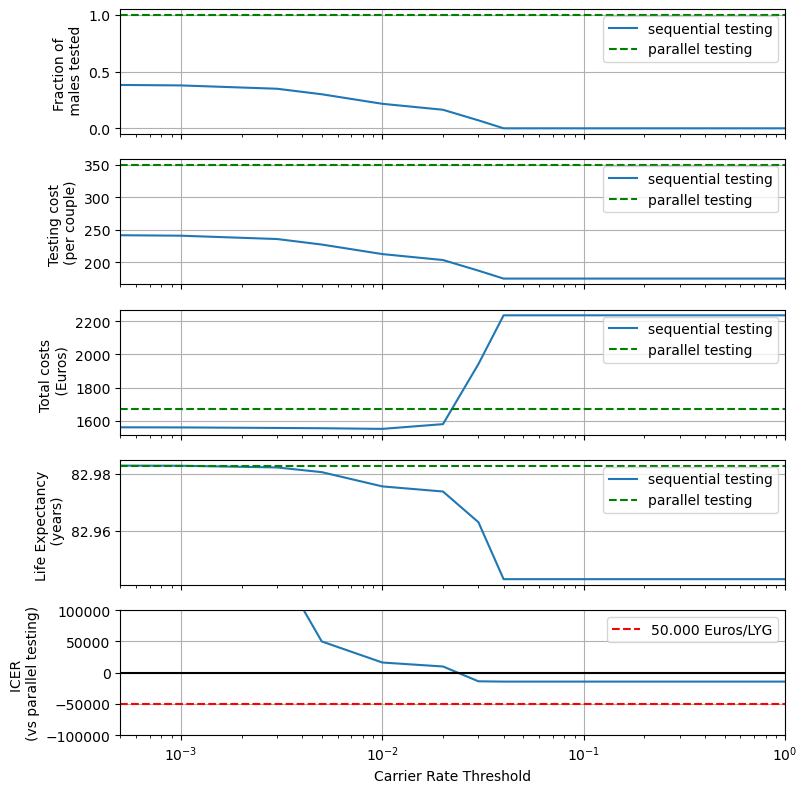

In [29]:
fig,ax = plt.subplots(5,1,figsize=(8,8),sharex=True)
sns.lineplot(df_icer_seq,x='threshold',y='pmale_sequential',ax=ax[0],label='sequential testing')
ax[0].axhline(strategy_parallel.pmale_testing,color='g',ls='--',label='parallel testing')
ax[0].legend()

sns.lineplot(df_icer_seq,x='threshold',y='testing_cost_sequential',ax=ax[1],label='sequential testing')
ax[1].axhline(strategy_parallel.testing_cost,color='g',ls='--',label='parallel testing')
ax[1].legend()


sns.lineplot(df_icer_seq,x='threshold',y='total cost2',ax=ax[2],label='sequential testing')
#ax[2].axhline(strategy_parallel.testing_cost,color='r',ls='--',label='parallel testing')
ax[2].axhline(df_icer_seq['total cost1'].values[0],color='g',ls='--',label='parallel testing')

ax[2].legend()

sns.lineplot(df_icer_seq,x='threshold',y='life exp2',ax=ax[3],label='sequential testing')
ax[3].axhline(df_icer_seq['life exp1'].values[0],color='g',ls='--',label='parallel testing')
ax[3].legend()

sns.lineplot(df_icer_seq,x='threshold',y='icer',ax=ax[4])
ax[4].set_ylim(-1e5,1e5)
ax[4].axhline(0,color='k')
ax[4].axhline(-50000,color='r',ls='--',label='50.000 Euros/LYG')
ax[4].legend()


plt.xlim([5e-4,1])
plt.tight_layout()
plt.xscale('log')
ax[0].grid()
ax[1].grid()
ax[2].grid()
ax[3].grid()
ax[4].grid()
ax[0].set_ylabel('Fraction of \n males tested')
ax[1].set_ylabel('Testing cost \n(per couple)')
ax[2].set_ylabel('Total costs \n (Euros)')
ax[3].set_ylabel('Life Expectancy \n (years)')
ax[4].set_ylabel('ICER \n(vs parallel testing)')
plt.xlabel('Carrier Rate Threshold')
plt.savefig(os.path.join(out_folder,'parallel_vs_sequential.jpeg'))
plt.savefig(os.path.join(out_folder,'parallel_vs_sequential.eps'))

# Sensitivity analysis

In [30]:
import pandas as pd

intervention_cost = 19714
rho_notint = 0.23
cost_A = dl.strategy_dict['Strategy A - ACMG tier 1'].testing_cost
cost_B = dl.strategy_dict['Strategy B - Focused Screening'].testing_cost
cost_C = dl.strategy_dict['Strategy C  - ACMG tier 3'].testing_cost

for strategy in dl.strategy_dict.keys():
    print(strategy,dl.strategy_dict[strategy].testing_cost)

Strategy B - Focused Screening 270
Strategy A - ACMG tier 1 180
Strategy C  - ACMG tier 3 350
No testing 0


/tmp/ipykernel_38867/956213074.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_38867/956213074.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_38867/956213074.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_38867/956213074.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_38867/956213074.py:43: FutureWarning: The frame.append method is deprecated and will be remov

/tmp/ipykernel_38867/956213074.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_38867/956213074.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_38867/956213074.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_38867/956213074.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_38867/956213074.py:43: FutureWarning: The frame.append method is deprecated and will be remov

/tmp/ipykernel_38867/956213074.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_38867/956213074.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_38867/956213074.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(


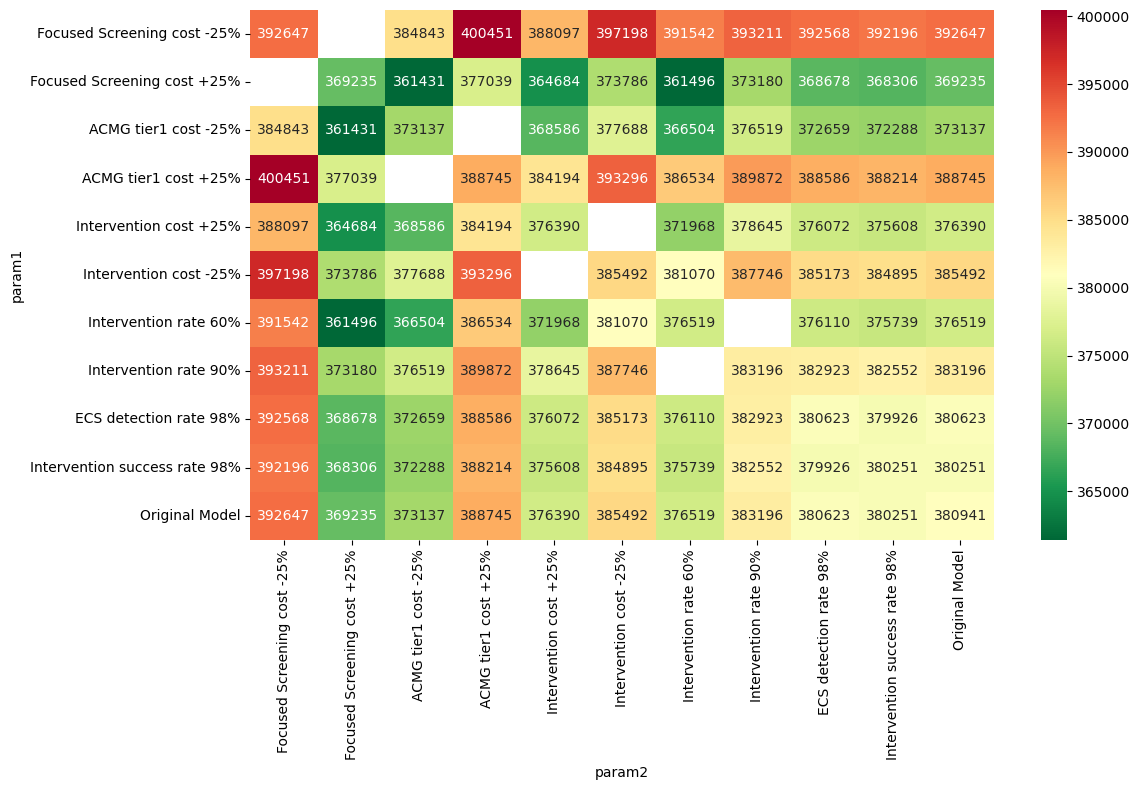

In [31]:
# A vs B


strategy1 = 'Strategy A - ACMG tier 1'
strategy2 = 'Strategy B - Focused Screening'



param_list = [
    ('testing_cost2',0.75*cost_B,'Focused Screening cost -25%'),
              ('testing_cost2',1.25*cost_B,'Focused Screening cost +25%'),
              ('testing_cost1',0.75*cost_A,'ACMG tier1 cost -25%'),
              ('testing_cost1',1.25*cost_A,'ACMG tier1 cost +25%'),
              ('intervention_cost',1.25*intervention_cost,'Intervention cost +25%'),
              ('intervention_cost',0.75*intervention_cost,'Intervention cost -25%'),
                ('rho_notint',0.4,'Intervention rate 60%'),
              ('rho_notint',0.1,'Intervention rate 90%'),
             ('eps_cs',0.02,'ECS detection rate 98%'),
             ('eps_pgt',0.02,'Intervention success rate 98%'),
    ('original_model_fake_parameter',0,'Original Model')]

df_icer_sensitivity = pd.DataFrame()

for param1 in param_list:
    for param2 in param_list:
        
        if (param1[1]!=param2[1])&(param1[0]==param2[0]):
            pass
        
        else:

            #print(param1,param2)

            icer = Icer(dl.strategy_dict[strategy1],dl.strategy_dict[strategy2],
                     eps_cs=0,eps_pgt=0,intervention_cost=intervention_cost,rho_notint=rho_notint)
            setattr(icer,param1[0],param1[1])
            setattr(icer,param2[0],param2[1])
            
            #print(param1[2],param2[2],icer.testing_cost1,icer.testing_cost2)


            icer.compute_icer()
            df_icer_sensitivity = df_icer_sensitivity.append(
            {'param1':param1[2],'param1_value':param1[1],
             'param2':param2[2],'param2_value':param2[1],
               'icer':icer.icer,
               'total cost1':icer.total_cost1,
               'total cost2':icer.total_cost2,
               'life exp1':icer.life_exp1,
               'life exp2':icer.life_exp2,
              'benefit difference (years)':icer.life_exp1-icer.life_exp2,
            'cost difference (Euros)':icer.total_cost1-icer.total_cost2},ignore_index=True)

df_pivot = df_icer_sensitivity.pivot_table(index='param1',columns='param2',values='icer')
params = [x[2] for x in param_list]
df_pivot = df_pivot.loc[params,params]

fig,ax = plt.subplots(figsize=(12,8))
sns.heatmap(ax=ax,data = df_pivot, annot=True, fmt=".0f",cmap='RdYlGn_r')
plt.tight_layout()
plt.savefig(os.path.join(out_folder,'bivariate_'+strategy1+'vs'+strategy2+'.jpeg'))
plt.savefig(os.path.join(out_folder,'bivariate_'+strategy1+'vs'+strategy2+'.eps'))

In [ ]:
# A vs C


strategy1 = 'Strategy A - ACMG tier 1'
strategy2 = 'Strategy C  - ACMG tier 3'



param_list = [
    ('testing_cost2',0.75*cost_C,'ACMG tier3 cost -25%'),
              ('testing_cost2',1.25*cost_C,'ACMG tier3 cost +25%'),
              ('testing_cost1',0.75*cost_A,'ACMG tier1 cost -25%'),
              ('testing_cost1',1.25*cost_A,'ACMG tier1 cost +25%'),
              ('intervention_cost',1.25*intervention_cost,'Intervention cost +25%'),
              ('intervention_cost',0.75*intervention_cost,'Intervention cost -25%'),
                ('rho_notint',0.4,'Intervention rate 60%'),
              ('rho_notint',0.1,'Intervention rate 90%'),
             ('eps_cs',0.02,'ECS detection rate 98%'),
             ('eps_pgt',0.02,'Intervention success rate 98%'),
    ('original_model_fake_parameter',0,'Original Model')]

df_icer_sensitivity = pd.DataFrame()

for param1 in param_list:
    for param2 in param_list:
        
        if (param1[1]!=param2[1])&(param1[0]==param2[0]):
            pass
        
        else:

            #print(param1,param2)

            icer = Icer(dl.strategy_dict[strategy1],dl.strategy_dict[strategy2],
                     eps_cs=0,eps_pgt=0,intervention_cost=intervention_cost,rho_notint=rho_notint)
            setattr(icer,param1[0],param1[1])
            setattr(icer,param2[0],param2[1])


            icer.compute_icer()
            df_icer_sensitivity = df_icer_sensitivity.append(
            {'param1':param1[2],'param1_value':param1[1],
             'param2':param2[2],'param2_value':param2[1],
               'icer':icer.icer,
               'total cost1':icer.total_cost1,
               'total cost2':icer.total_cost2,
               'life exp1':icer.life_exp1,
               'life exp2':icer.life_exp2,
              'benefit difference (years)':icer.life_exp1-icer.life_exp2,
            'cost difference (Euros)':icer.total_cost1-icer.total_cost2},ignore_index=True)

df_pivot = df_icer_sensitivity.pivot_table(index='param1',columns='param2',values='icer')
params = [x[2] for x in param_list]
df_pivot = df_pivot.loc[params,params]

fig,ax = plt.subplots(figsize=(12,8))
sns.heatmap(ax=ax,data = df_pivot, annot=True, fmt=".0f",cmap='RdYlGn_r')
plt.tight_layout()
plt.savefig(os.path.join(out_folder,'bivariate_'+strategy1+'vs'+strategy2+'.eps'))
plt.savefig(os.path.join(out_folder,'bivariate_'+strategy1+'vs'+strategy2+'.jpeg'))

/tmp/ipykernel_38867/4261447874.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_38867/4261447874.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_38867/4261447874.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_38867/4261447874.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_38867/4261447874.py:41: FutureWarning: The frame.append method is deprecated and will be 

/tmp/ipykernel_38867/4261447874.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_38867/4261447874.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_38867/4261447874.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_38867/4261447874.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_38867/4261447874.py:41: FutureWarning: The frame.append method is deprecated and will be 

In [ ]:
# B vs C


strategy1 = 'Strategy B - Focused Screening'
strategy2 = 'Strategy C  - ACMG tier 3'



param_list = [
    ('testing_cost2',0.75*cost_C,'ACMG tier3 cost -25%'),
              ('testing_cost2',1.25*cost_C,'ACMG tier3 cost +25%'),
              ('testing_cost1',0.75*cost_B,'Focused Screening cost -25%'),
              ('testing_cost1',1.25*cost_B,'Focused Screening cost +25%'),
              ('intervention_cost',1.25*intervention_cost,'Intervention cost +25%'),
              ('intervention_cost',0.75*intervention_cost,'Intervention cost -25%'),
                ('rho_notint',0.4,'Intervention rate 60%'),
              ('rho_notint',0.1,'Intervention rate 90%'),
             ('eps_cs',0.02,'ECS detection rate 98%'),
             ('eps_pgt',0.02,'Intervention success rate 98%'),
    ('original_model_fake_parameter',0,'Original Model')]

df_icer_sensitivity = pd.DataFrame()

for param1 in param_list:
    for param2 in param_list:
        
        if (param1[1]!=param2[1])&(param1[0]==param2[0]):
            pass
        
        else:

            #print(param1,param2)

            icer = Icer(dl.strategy_dict[strategy1],dl.strategy_dict[strategy2],
                     eps_cs=0,eps_pgt=0,intervention_cost=intervention_cost,rho_notint=rho_notint)
            setattr(icer,param1[0],param1[1])
            setattr(icer,param2[0],param2[1])


            icer.compute_icer()
            df_icer_sensitivity = df_icer_sensitivity.append(
            {'param1':param1[2],'param1_value':param1[1],
             'param2':param2[2],'param2_value':param2[1],
               'icer':icer.icer,
               'total cost1':icer.total_cost1,
               'total cost2':icer.total_cost2,
               'life exp1':icer.life_exp1,
               'life exp2':icer.life_exp2,
              'benefit difference (years)':icer.life_exp1-icer.life_exp2,
            'cost difference (Euros)':icer.total_cost1-icer.total_cost2},ignore_index=True)

df_pivot = df_icer_sensitivity.pivot_table(index='param1',columns='param2',values='icer')
params = [x[2] for x in param_list]
df_pivot = df_pivot.loc[params,params]

fig,ax = plt.subplots(figsize=(12,8))
sns.heatmap(ax=ax,data = df_pivot, annot=True, fmt=".0f",cmap='RdYlGn_r')
plt.tight_layout()
plt.savefig(os.path.join(out_folder,'bivariate_'+strategy1+'vs'+strategy2+'.eps'))
plt.savefig(os.path.join(out_folder,'bivariate_'+strategy1+'vs'+strategy2+'.jpeg'))

In [ ]:
# A vs no testing


strategy1 = 'Strategy A - ACMG tier 1'
strategy2 = 'No testing'



param_list = [
    ('testing_cost1',0.75*cost_A,'ACMG tier1 cost -25%'),
              ('testing_cost1',1.25*cost_A,'ACMG tier1 cost +25%'),
              ('intervention_cost',1.25*intervention_cost,'Intervention cost +25%'),
              ('intervention_cost',0.75*intervention_cost,'Intervention cost -25%'),
                ('rho_notint',0.4,'Intervention rate 60%'),
              ('rho_notint',0.1,'Intervention rate 90%'),
             ('eps_cs',0.02,'ECS detection rate 98%'),
             ('eps_pgt',0.02,'Intervention success rate 98%'),
    ('original_model_fake_parameter',0,'Original Model')]


df_icer_sensitivity = pd.DataFrame()

for idx1 in range(len(param_list)):
    for idx2 in range(len(param_list)):
        
        param1 = param_list[idx1]
        param2 = param_list[idx2]
        #print(param1,param2)

        
        if (param1[1]!=param2[1])&(param1[0]==param2[0]):
            pass
        
        else:
        
        
            icer = Icer(dl.strategy_dict[strategy1],dl.strategy_dict[strategy2],
                     eps_cs=0,eps_pgt=0,intervention_cost=intervention_cost,rho_notint=rho_notint)
            setattr(icer,param1[0],param1[1])
            setattr(icer,param2[0],param2[1])


            icer.compute_icer()
            df_icer_sensitivity = df_icer_sensitivity.append(
            {'param1':param1[2],'param1_value':param1[1],
             'param2':param2[2],'param2_value':param2[1],
               'icer':icer.icer,
               'total cost1':icer.total_cost1,
               'total cost2':icer.total_cost2,
               'life exp1':icer.life_exp1,
               'life exp2':icer.life_exp2,
              'benefit difference (years)':icer.life_exp1-icer.life_exp2,
            'cost difference (Euros)':icer.total_cost1-icer.total_cost2},ignore_index=True)

df_pivot = df_icer_sensitivity.pivot_table(index='param1',columns='param2',values='icer')
params = [x[2] for x in param_list]
#df_pivot = df_pivot.loc[params,params]

fig,ax = plt.subplots(figsize=(12,8))
sns.heatmap(ax=ax,data = df_pivot, annot=True, fmt=".0f",cmap='RdYlGn_r')
plt.tight_layout()
plt.savefig(os.path.join(out_folder,'bivariate_'+strategy1+'vs'+strategy2+'.eps'))
plt.savefig(os.path.join(out_folder,'bivariate_'+strategy1+'vs'+strategy2+'.jpeg'))

In [ ]:
# B vs no testing


strategy1 = 'Strategy B - Focused Screening'
strategy2 = 'No testing'

param_list = [
    ('testing_cost1',0.75*cost_B,'Focused Screening cost -25%'),
              ('testing_cost1',1.25*cost_B,'Focused Screening cost +25%'),
              ('intervention_cost',1.25*intervention_cost,'Intervention cost +25%'),
              ('intervention_cost',0.75*intervention_cost,'Intervention cost -25%'),
                ('rho_notint',0.4,'Intervention rate 60%'),
              ('rho_notint',0.1,'Intervention rate 90%'),
             ('eps_cs',0.02,'ECS detection rate 98%'),
             ('eps_pgt',0.02,'Intervention success rate 98%'),
    ('original_model_fake_parameter',0,'Original Model')]


df_icer_sensitivity = pd.DataFrame()

for idx1 in range(len(param_list)):
    for idx2 in range(len(param_list)):
        
        param1 = param_list[idx1]
        param2 = param_list[idx2]
        #print(param1,param2)

        
        if (param1[1]!=param2[1])&(param1[0]==param2[0]):
            pass
        
        else:
        
        
            icer = Icer(dl.strategy_dict[strategy1],dl.strategy_dict[strategy2],
                     eps_cs=0,eps_pgt=0,intervention_cost=intervention_cost,rho_notint=rho_notint)
            setattr(icer,param1[0],param1[1])
            setattr(icer,param2[0],param2[1])


            icer.compute_icer()
            df_icer_sensitivity = df_icer_sensitivity.append(
            {'param1':param1[2],'param1_value':param1[1],
             'param2':param2[2],'param2_value':param2[1],
               'icer':icer.icer,
               'total cost1':icer.total_cost1,
               'total cost2':icer.total_cost2,
               'life exp1':icer.life_exp1,
               'life exp2':icer.life_exp2,
              'benefit difference (years)':icer.life_exp1-icer.life_exp2,
            'cost difference (Euros)':icer.total_cost1-icer.total_cost2},ignore_index=True)

df_pivot = df_icer_sensitivity.pivot_table(index='param1',columns='param2',values='icer')
params = [x[2] for x in param_list]
#df_pivot = df_pivot.loc[params,params]

fig,ax = plt.subplots(figsize=(12,8))
sns.heatmap(ax=ax,data = df_pivot, annot=True, fmt=".0f",cmap='RdYlGn_r')
plt.tight_layout()
plt.savefig(os.path.join(out_folder,'bivariate_'+strategy1+'vs'+strategy2+'.eps'))
plt.savefig(os.path.join(out_folder,'bivariate_'+strategy1+'vs'+strategy2+'.jpeg'))

In [ ]:
# C vs no testing


strategy1 = 'Strategy C  - ACMG tier 3'
strategy2 = 'No testing'

param_list = [
    ('testing_cost1',0.75*cost_C,'ACMG Tier3 cost -25%'),
              ('testing_cost1',1.25*cost_C,'ACMG Tier3 cost +25%'),
              ('intervention_cost',1.25*intervention_cost,'Intervention cost +25%'),
              ('intervention_cost',0.75*intervention_cost,'Intervention cost -25%'),
                ('rho_notint',0.4,'Intervention rate 60%'),
              ('rho_notint',0.1,'Intervention rate 90%'),
             ('eps_cs',0.02,'ECS detection rate 98%'),
             ('eps_pgt',0.02,'Intervention success rate 98%'),
    ('original_model_fake_parameter',0,'Original Model')]


df_icer_sensitivity = pd.DataFrame()

for idx1 in range(len(param_list)):
    for idx2 in range(len(param_list)):
        
        param1 = param_list[idx1]
        param2 = param_list[idx2]
        #print(param1,param2)

        
        if (param1[1]!=param2[1])&(param1[0]==param2[0]):
            pass
        
        else:
        
        
            icer = Icer(dl.strategy_dict[strategy1],dl.strategy_dict[strategy2],
                     eps_cs=0,eps_pgt=0,intervention_cost=intervention_cost,rho_notint=rho_notint)
            setattr(icer,param1[0],param1[1])
            setattr(icer,param2[0],param2[1])


            icer.compute_icer()
            df_icer_sensitivity = df_icer_sensitivity.append(
            {'param1':param1[2],'param1_value':param1[1],
             'param2':param2[2],'param2_value':param2[1],
               'icer':icer.icer,
               'total cost1':icer.total_cost1,
               'total cost2':icer.total_cost2,
               'life exp1':icer.life_exp1,
               'life exp2':icer.life_exp2,
              'benefit difference (years)':icer.life_exp1-icer.life_exp2,
            'cost difference (Euros)':icer.total_cost1-icer.total_cost2},ignore_index=True)

df_pivot = df_icer_sensitivity.pivot_table(index='param1',columns='param2',values='icer')
params = [x[2] for x in param_list]
#df_pivot = df_pivot.loc[params,params]

fig,ax = plt.subplots(figsize=(12,8))
sns.heatmap(ax=ax,data = df_pivot, annot=True, fmt=".0f",cmap='RdYlGn_r')
plt.tight_layout()
plt.savefig(os.path.join(out_folder,'bivariate_'+strategy1+'vs'+strategy2+'.eps'))
plt.savefig(os.path.join(out_folder,'bivariate_'+strategy1+'vs'+strategy2+'.jpeg'))

# Probabilistic analysis

In [ ]:

strategy1 = 'Strategy A - ACMG tier 1'
strategy2 = 'Strategy B - Focused Screening'

psa = Psa(dl.strategy_dict[strategy1],dl.strategy_dict[strategy2])
psa.run_mc(
    intervention_cost_lb=intervention_cost*0.75, intervention_cost_ub=intervention_cost*1.25,
       testing_cost1_lb=0.75*cost_A, testing_cost1_ub=1.25*cost_A,
        testing_cost2_lb=0.75*cost_B, testing_cost2_ub=1.25*cost_B,
        eps_cs_lb=0,eps_cs_ub=0.02,
        eps_pgt_lb=0,eps_pgt_ub=0.02,
        rho_notint_lb=0.1,rho_notint_ub=0.4,nsim=10000)



outfile = os.path.join(out_folder,'psa_'+strategy1+'vs'+strategy2+'.jpeg')
psa.plot_ceac_hist(outfile=outfile,title='CEAC diagram: ACMG tier1 vs Focused Screening')

outfile = os.path.join(out_folder,'psa_'+strategy1+'vs'+strategy2+'.eps')
psa.plot_ceac_hist(outfile=outfile,title='CEAC diagram: ACMG tier1 vs Focused Screening')

In [ ]:
import numpy as np
print(np.mean(psa.icer_mc_samples))
print(np.std(psa.icer_mc_samples))
print(np.std(psa.icer_mc_samples)/np.mean(psa.icer_mc_samples))

In [ ]:

strategy1 = 'Strategy A - ACMG tier 1'
strategy2 = 'Strategy C  - ACMG tier 3'

psa = Psa(dl.strategy_dict[strategy1],dl.strategy_dict[strategy2])
psa.run_mc(
    intervention_cost_lb=intervention_cost*0.75, intervention_cost_ub=intervention_cost*1.25,
       testing_cost1_lb=0.75*cost_A, testing_cost1_ub=1.25*cost_A,
        testing_cost2_lb=0.75*cost_C, testing_cost2_ub=1.25*cost_C,
        eps_cs_lb=0,eps_cs_ub=0.02,
        eps_pgt_lb=0,eps_pgt_ub=0.02,
        rho_notint_lb=0.1,rho_notint_ub=0.4,nsim=10000)



outfile = os.path.join(out_folder,'psa_'+strategy1+'vs'+strategy2+'.jpeg')
psa.plot_ceac_hist(outfile=outfile,title='CEAC diagram: ACMG tier1 vs ACMG tier3')

outfile = os.path.join(out_folder,'psa_'+strategy1+'vs'+strategy2+'.eps')
psa.plot_ceac_hist(outfile=outfile,title='CEAC diagram: ACMG tier1 vs ACMG tier3')

In [ ]:
print(np.mean(psa.icer_mc_samples))
print(np.std(psa.icer_mc_samples))
print(np.std(psa.icer_mc_samples)/np.mean(psa.icer_mc_samples))

In [ ]:

strategy1 = 'Strategy B - Focused Screening'
strategy2 = 'Strategy C  - ACMG tier 3'

psa = Psa(dl.strategy_dict[strategy1],dl.strategy_dict[strategy2])
psa.run_mc(
    intervention_cost_lb=intervention_cost*0.75, intervention_cost_ub=intervention_cost*1.25,
       testing_cost1_lb=0.75*cost_B, testing_cost1_ub=1.25*cost_B,
        testing_cost2_lb=0.75*cost_C, testing_cost2_ub=1.25*cost_C,
        eps_cs_lb=0,eps_cs_ub=0.02,
        eps_pgt_lb=0,eps_pgt_ub=0.02,
        rho_notint_lb=0.1,rho_notint_ub=0.4,nsim=10000)



outfile = os.path.join(out_folder,'psa_'+strategy1+'vs'+strategy2+'.jpeg')
psa.plot_ceac_hist(outfile=outfile,title='CEAC diagram: Focused Screening vs ACMG tier3')

outfile = os.path.join(out_folder,'psa_'+strategy1+'vs'+strategy2+'.eps')
psa.plot_ceac_hist(outfile=outfile,title='CEAC diagram: Focused Screening vs ACMG tier3')

In [ ]:
print(np.mean(psa.icer_mc_samples))
print(np.std(psa.icer_mc_samples))
print(np.std(psa.icer_mc_samples)/np.mean(psa.icer_mc_samples))

In [ ]:
psa.icer_mc_samples

In [ ]:

strategy1 = 'Strategy A - ACMG tier 1'
strategy2 = 'No testing'

psa = Psa(dl.strategy_dict[strategy1],dl.strategy_dict[strategy2])
psa.run_mc(
    intervention_cost_lb=intervention_cost*0.75, intervention_cost_ub=intervention_cost*1.25,
       testing_cost1_lb=0.75*cost_A, testing_cost1_ub=1.25*cost_A,
        testing_cost2_lb=0, testing_cost2_ub=0,
        eps_cs_lb=0,eps_cs_ub=0.02,
        eps_pgt_lb=0,eps_pgt_ub=0.02,
        rho_notint_lb=0.1,rho_notint_ub=0.4,nsim=10000)


outfile = os.path.join(out_folder,'psa_'+strategy1+'vs'+strategy2+'.eps')
psa.plot_ceac_hist(outfile=outfile,title='CEAC diagram: ACMG tier1 vs No screening')

outfile = os.path.join(out_folder,'psa_'+strategy1+'vs'+strategy2+'.jpeg')
psa.plot_ceac_hist(outfile=outfile,title='CEAC diagram: ACMG tier1 vs No screening')

In [ ]:
print(np.mean(psa.icer_mc_samples))
print(np.std(psa.icer_mc_samples))
print(np.std(psa.icer_mc_samples)/np.mean(psa.icer_mc_samples))

In [ ]:

strategy1 = 'Strategy B - Focused Screening'
strategy2 = 'No testing'

psa = Psa(dl.strategy_dict[strategy1],dl.strategy_dict[strategy2])
psa.run_mc(
    intervention_cost_lb=intervention_cost*0.75, intervention_cost_ub=intervention_cost*1.25,
       testing_cost1_lb=0.75*cost_B, testing_cost1_ub=1.25*cost_B,
        testing_cost2_lb=0, testing_cost2_ub=0,
        eps_cs_lb=0,eps_cs_ub=0.02,
        eps_pgt_lb=0,eps_pgt_ub=0.02,
        rho_notint_lb=0.1,rho_notint_ub=0.4,nsim=10000)


outfile = os.path.join(out_folder,'psa_'+strategy1+'vs'+strategy2+'.eps')
psa.plot_ceac_hist(outfile=outfile,title='CEAC diagram: Focused Screening vs No screening')

outfile = os.path.join(out_folder,'psa_'+strategy1+'vs'+strategy2+'.jpeg')
psa.plot_ceac_hist(outfile=outfile,title='CEAC diagram: Focused Screening vs No screening')

In [ ]:
print(np.mean(psa.icer_mc_samples))
print(np.std(psa.icer_mc_samples))
print(np.std(psa.icer_mc_samples)/np.mean(psa.icer_mc_samples))

In [ ]:

strategy1 = 'Strategy C  - ACMG tier 3'
strategy2 = 'No testing'

psa = Psa(dl.strategy_dict[strategy1],dl.strategy_dict[strategy2])
psa.run_mc(
    intervention_cost_lb=intervention_cost*0.75, intervention_cost_ub=intervention_cost*1.25,
       testing_cost1_lb=0.75*cost_C, testing_cost1_ub=1.25*cost_C,
        testing_cost2_lb=0, testing_cost2_ub=0,
        eps_cs_lb=0,eps_cs_ub=0.02,
        eps_pgt_lb=0,eps_pgt_ub=0.02,
        rho_notint_lb=0.1,rho_notint_ub=0.4,nsim=10000)


outfile = os.path.join(out_folder,'psa_'+strategy1+'vs'+strategy2+'.eps')
psa.plot_ceac_hist(outfile=outfile,title='CEAC diagram: ACMG tier3 vs No screening')

outfile = os.path.join(out_folder,'psa_'+strategy1+'vs'+strategy2+'.jpeg')
psa.plot_ceac_hist(outfile=outfile,title='CEAC diagram: ACMG tier3 vs No screening')

In [ ]:
print(np.mean(psa.icer_mc_samples))
print(np.std(psa.icer_mc_samples))
print(np.std(psa.icer_mc_samples)/np.mean(psa.icer_mc_samples))

In [ ]:
psa.plot_ceac()